# Необходимые библиотеки

In [4]:
import pandas as pd
import numpy as np

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from scipy.stats import chi2_contingency

In [7]:
from tqdm import tqdm

# Загрузка данных

In [8]:
data = pd.read_csv('cleared_data.csv')
data.head()

,vacancy_id,employer_id,employees_number,creation_date,work_schedule,employment,length_of_employment,compensation_from,compensation_to,accept_teenagers,...,young_male_response_count,invitation_count,female_invitation_count,male_invitation_count,young_invitation_count,young_female_invitation_count,young_male_invitation_count,industry_id_list,correct_salary,length_industry_list
0,78161908,4809555,50,2023-03-17,shift,full,no_experience,22500.0,22500.0,False,...,1,26,26,0,2,2,0,[None],approximately,0
1,79496395,5667513,5,2023-04-19,shift,full,up_to_3_years,24000.0,30000.0,False,...,0,3,3,0,0,0,0,[None],correct,0
2,87102246,1072323,0,2023-09-21,full_day,full,up_to_3_years,50000.0,50000.0,False,...,0,9,7,2,0,0,0,"[7, 8]",approximately,2
3,76367381,1160192,0,2023-01-30,full_day,full,up_to_3_years,55000.0,150000.0,False,...,0,49,39,10,0,0,0,"[5, 13]",correct,2
4,81516485,1025275,38000,2023-06-05,shift,full,no_experience,38500.0,56500.0,False,...,1,13,0,13,1,0,1,"[8, 41]",correct,2


## Изменяю тип creation_date

# Определение категориальных и количественных признаков

In [9]:
num_cols = data.select_dtypes('number').columns
cat_cols = data.columns.drop(num_cols)

num_cols = num_cols.drop(['vacancy_id', 'employer_id'])

In [10]:
num_cat_correlation_matrix = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=np.float64)

In [11]:
for num_col in tqdm(num_cols, total=len(num_cols), desc='Processing Numeric Columns'):
    for cat_col in cat_cols:
        groups = [data[num_col][data[cat_col] == value] for value in data[cat_col].unique()]
        
        total_variance = np.var(data[num_col], ddof=1)
        group_means = [g.mean() for g in groups]
        group_sizes = [len(g) for g in groups]
        group_variance = sum(size * (mean - data[num_col].mean()) ** 2 for size, mean in zip(group_sizes, group_means)) / len(data)

        eta_squared = group_variance / total_variance
        num_cat_correlation_matrix.loc[cat_col, num_col] = eta_squared

Processing Numeric Columns:   0%|          | 0/16 [00:00<?, ?it/s]

Processing Numeric Columns: 100%|██████████| 16/16 [10:11<00:00, 38.21s/it]


In [12]:
num_cat_correlation_matrix_adj = num_cat_correlation_matrix.T.loc[['compensation_to', 'compensation_from', 'response_count', 'invitation_count'], ['work_schedule', 'specialization', 'region_name']]

In [13]:
num_cat_correlation_matrix_adj.columns = ['график работы', 'профессия', 'регион']
num_cat_correlation_matrix_adj.index = ['зарплата мин', 'зарплата макс', 'число откликов', 'число приглашений']

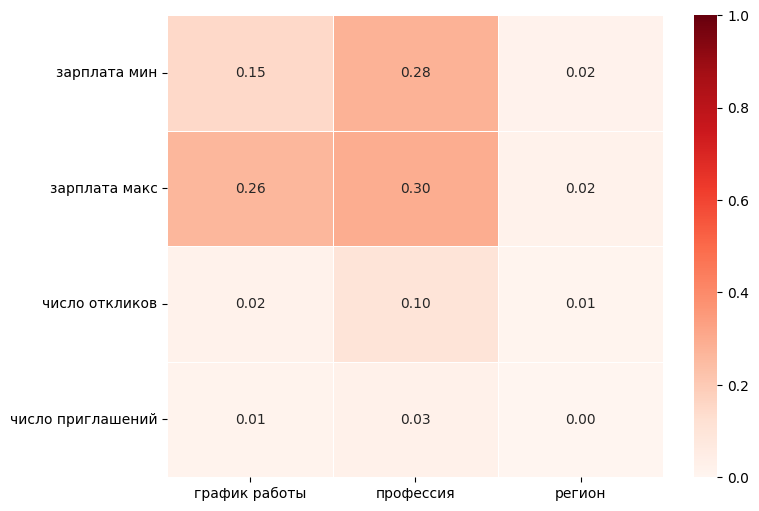

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(num_cat_correlation_matrix_adj, annot=True, cmap='Reds', fmt=".2f", linewidths=0.5, vmin=0, vmax=1 )

plt.show()

In [44]:
cat_cat_correlation_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=np.float64)

In [45]:
def cramers_v(chi2, n, k, r):
    return np.sqrt(chi2 / (n * min(k - 1, r - 1)))


for i in tqdm(range(len(cat_cols) - 1)):
    for j in range(i, len(cat_cols)):
        first_col = cat_cols[i]
        second_col = cat_cols[j]

        cross_tab = pd.crosstab(data[first_col], data[second_col])
        chi2, p_value, dof, _ = chi2_contingency(cross_tab)

        n = cross_tab.values.sum()
        k = cross_tab.shape[0]
        r = cross_tab.shape[1]
        
        if p_value > 0.05:
            v = 0
        else:
            v = cramers_v(chi2, n, k, r)
        
        cat_cat_correlation_matrix.loc[first_col, second_col] = v
        cat_cat_correlation_matrix.loc[second_col, first_col] = v

100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


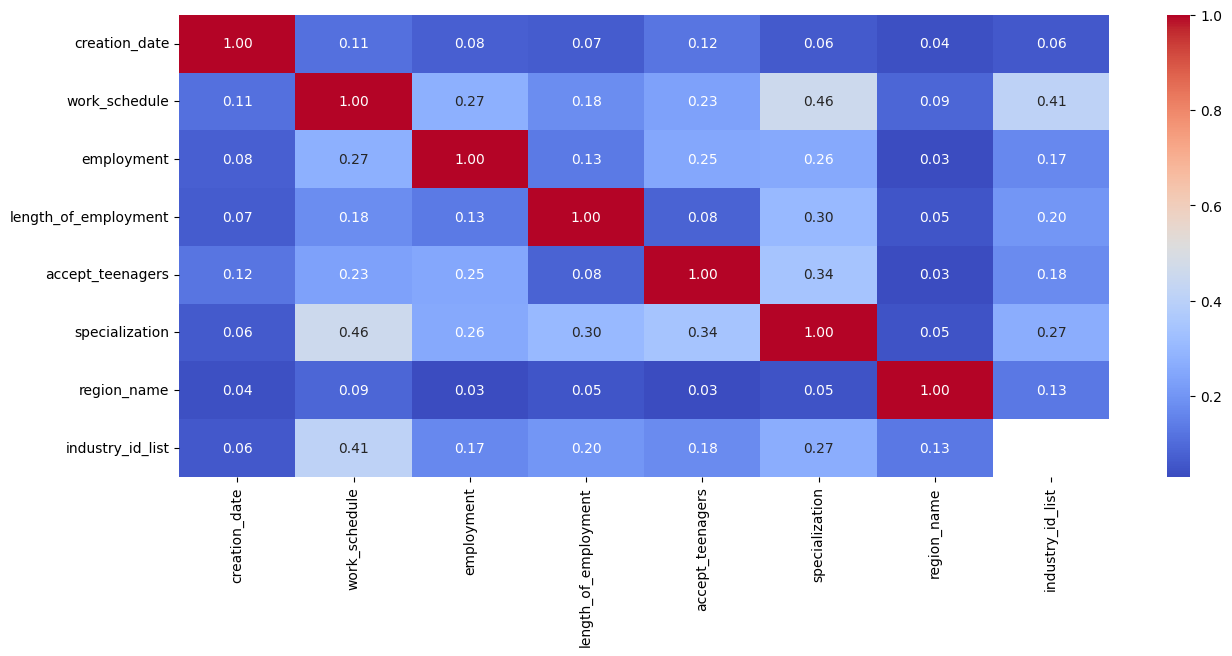

In [46]:
plt.figure(figsize=(15, 6))
sns.heatmap(cat_cat_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.show()